In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings

warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 20)


In [4]:
data = pd.read_csv('turbo_az_2022-10-26.csv')
data.head()

,sheher,marka,model,buraxilish_ili,ban_novu,reng,muherrik,muherrikin_gucu,yanacaq_novu,yurush,karobka,oturucu,yeni,qiymet,elan_id,yenilendi,extras,info,baxish_sayi,url
0,Bakı,Toyota,Land Cruiser,2022,Offroader / SUV,Qara,4.0 L,272 a.g.,Benzin,0 km,Avtomat,Tam,Bəli,88 500 $,Elanın nömrəsi: ...,Yeniləndi: 26.10...,['Yüngül lehimli...,Toyota-Lexus şir...,Baxışların sayı:...,https://turbo.az...
1,Sumqayıt,Mercedes,C 250,2006,Sedan,Ağ,2.5 L,204 a.g.,Benzin,273 221 km,Avtomat,Arxa,Xeyr,14 800 AZN,Elanın nömrəsi: ...,Yeniləndi: 26.10...,['Yüngül lehimli...,Avtomobillərin a...,Baxışların sayı:...,https://turbo.az...
2,Sumqayıt,Mercedes,E 220,2001,Sedan,Bej,2.2 L,143 a.g.,Dizel,300 000 km,Avtomat,Arxa,Xeyr,15 800 AZN,Elanın nömrəsi: ...,Yeniləndi: 26.10...,['Yüngül lehimli...,Avtomobillərin a...,Baxışların sayı:...,https://turbo.az...
3,Bakı,Hyundai,i30,2009,Hetçbek,Qara,1.4 L,109 a.g.,Benzin,185 674 km,Mexaniki,Ön,Xeyr,11 900 AZN,Elanın nömrəsi: ...,Yeniləndi: 26.10...,['Yüngül lehimli...,NaN,Baxışların sayı: 71,https://turbo.az...
4,Bakı,Mercedes,E 240,2001,Sedan,Göy,2.4 L,170 a.g.,Benzin,178 000 km,Avtomat,Arxa,Xeyr,14 700 AZN,Elanın nömrəsi: ...,Yeniləndi: 26.10...,['Yüngül lehimli...,Masinda hec bir ...,Baxışların sayı: 61,https://turbo.az...


In [5]:
def data_clean(data):
    data['valyuta'] = data['qiymet'].apply(lambda x: x.split()[-1])
    data['qiymet'] = data['qiymet'].apply(lambda x: ''.join(x.split()[:-1])).astype(float)
    data['yurush'] = data.yurush.str.strip('km').str.replace(' ', '').astype('float32')
    data['muherrikin_gucu'] = data.muherrikin_gucu.str.strip(' a.g.').str.replace(' ', '').astype('float16')
    data['muherrik'] = data['muherrik'].apply(lambda x: x.split()[0]).astype('float16')
    data['car_age'] = 2022 - data.buraxilish_ili

    data['qiymet_azn'] = np.select(condlist=[data.valyuta == '$', data.valyuta == 'AZN', data.valyuta == '€'],
                                   choicelist=[data.qiymet * 1.7, data.qiymet, data.qiymet * 1.68],
                                   default=data.qiymet)
    data['yeni'] = np.select(condlist=[data['yeni'] == 'Xeyr', data['yeni'] == 'Bəli'],
                             choicelist=[1, 0],
                             default=data.yeni)
    data['elan_id'] = data['elan_id'].apply(lambda x: x.split()[2]).astype(int)
    data['baxish_sayi'] = data['baxish_sayi'].apply(lambda x: x.split()[2]).astype(int)
    data['yenilendi'] = pd.to_datetime(data['yenilendi'].apply(lambda x: x.split()[1]))

    
    
    extra = np.array(['Yüngül lehimli disklər', 'ABS', 'Yağış sensoru',
                  'Mərkəzi qapanma', 'Park radarı', 'Kondisioner',
                  'Oturacaqların isidilməsi', 'Dəri salon', 'Ksenon lampalar',
                  'Arxa görüntü kamerası', 'Yan pərdələr',
                  'Oturacaqların ventilyasiyası'])
    
    for col in extra:
        arr = np.array([], dtype=np.int8)
        for i in data.extras:
            try:
                if col in eval(i):
                    arr = np.append(arr, 1)

                else:
                    arr = np.append(arr, 0)
            except:
                arr = np.append(arr, 0)

        data[col.lower().replace(' ', '_')] = arr
        data[col.lower().replace(' ', '_')] = data[col.lower().replace(' ', '_')].astype('int8')
        

    data['sheher_baki'] = np.select(condlist=[data.sheher == 'Bakı'], choicelist=[1], default=0)
    data['tecili'] = np.select(condlist=[data['info'].str.contains('tecili|təcili|təəcili|teecili|teciili', 
                                                                   na=False)], choicelist=[1], default=0)
    
    cols_to_drop = ['valyuta', 'qiymet', 'extras', 'info']
    data.drop(cols_to_drop, axis=1, inplace=True)
    data = data[data.ban_novu != 'Karvan']
    
    data = pd.concat([data, pd.get_dummies(data.karobka, prefix='karobka',drop_first=True)], axis=1)
    data = pd.concat([data, pd.get_dummies(data.ban_novu, prefix='ban_novu',drop_first=True)], axis=1)
    data = pd.concat([data, pd.get_dummies(data.reng, prefix='reng',drop_first=True)], axis=1)
    data = pd.concat([data, pd.get_dummies(data.yanacaq_novu, prefix='yanacaq_novu',drop_first=True)], axis=1)
    data = pd.concat([data, pd.get_dummies(data.oturucu, prefix='oturucu',drop_first=True)], axis=1)
    
    return data


data = data_clean(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10006 entries, 0 to 10007
Data columns (total 76 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   sheher                        10006 non-null  object        
 1   marka                         10006 non-null  object        
 2   model                         10006 non-null  object        
 3   buraxilish_ili                10006 non-null  int64         
 4   ban_novu                      10006 non-null  object        
 5   reng                          10006 non-null  object        
 6   muherrik                      10006 non-null  float16       
 7   muherrikin_gucu               10006 non-null  float16       
 8   yanacaq_novu                  10006 non-null  object        
 9   yurush                        10006 non-null  float32       
 10  karobka                       10006 non-null  object        
 11  oturucu                       100

In [7]:
data.head()

,sheher,marka,model,buraxilish_ili,ban_novu,reng,muherrik,muherrikin_gucu,yanacaq_novu,yurush,karobka,oturucu,yeni,elan_id,yenilendi,baxish_sayi,url,car_age,qiymet_azn,yüngül_lehimli_disklər,abs,yağış_sensoru,mərkəzi_qapanma,park_radarı,kondisioner,oturacaqların_isidilməsi,dəri_salon,ksenon_lampalar,arxa_görüntü_kamerası,yan_pərdələr,oturacaqların_ventilyasiyası,sheher_baki,tecili,karobka_Mexaniki,karobka_Robotlaşdırılmış,karobka_Variator,ban_novu_Dartqı,ban_novu_Furqon,ban_novu_Hetçbek,ban_novu_Kabriolet,ban_novu_Kupe,ban_novu_Liftbek,ban_novu_Mikroavtobus,ban_novu_Minivan,ban_novu_Moped,ban_novu_Motosiklet,ban_novu_Offroader / SUV,ban_novu_Pikap,ban_novu_Rodster,ban_novu_Sedan,ban_novu_Universal,ban_novu_Van,ban_novu_Yük maşını,reng_Bej,reng_Boz,reng_Bənövşəyi,reng_Göy,reng_Gümüşü,reng_Mavi,reng_Narıncı,reng_Qara,reng_Qırmızı,reng_Qızılı,reng_Qəhvəyi,reng_Sarı,reng_Tünd qırmızı,reng_Yaş Asfalt,reng_Yaşıl,reng_Çəhrayı,yanacaq_novu_Dizel,yanacaq_novu_Elektro,yanacaq_novu_Hibrid,yanacaq_novu_Plug-in Hibrid,yanacaq_novu_Qaz,oturucu_Tam,oturucu_Ön
0,Bakı,Toyota,Land Cruiser,2022,Offroader / SUV,Qara,4.000000,272.0,Benzin,0.0,Avtomat,Tam,0,6195108,2022-10-26,16687,https://turbo.az...,0,150450.0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,Sumqayıt,Mercedes,C 250,2006,Sedan,Ağ,2.500000,204.0,Benzin,273221.0,Avtomat,Arxa,1,6669253,2022-10-26,12320,https://turbo.az...,16,14800.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Sumqayıt,Mercedes,E 220,2001,Sedan,Bej,2.199219,143.0,Dizel,300000.0,Avtomat,Arxa,1,6685031,2022-10-26,12989,https://turbo.az...,21,15800.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,Bakı,Hyundai,i30,2009,Hetçbek,Qara,1.400391,109.0,Benzin,185674.0,Mexaniki,Ön,1,6768839,2022-10-26,71,https://turbo.az...,13,11900.0,1,1,0,1,0,1,1,0,0,0,1,0,1,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,Bakı,Mercedes,E 240,2001,Sedan,Göy,2.400391,170.0,Benzin,178000.0,Avtomat,Arxa,1,6768838,2022-10-26,61,https://turbo.az...,21,14700.0,1,1,1,1,1,1,1,1,0,0,1,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
sns.set(style='darkgrid', palette='dark')

Text(0.5, 1.0, 'Model sayi')

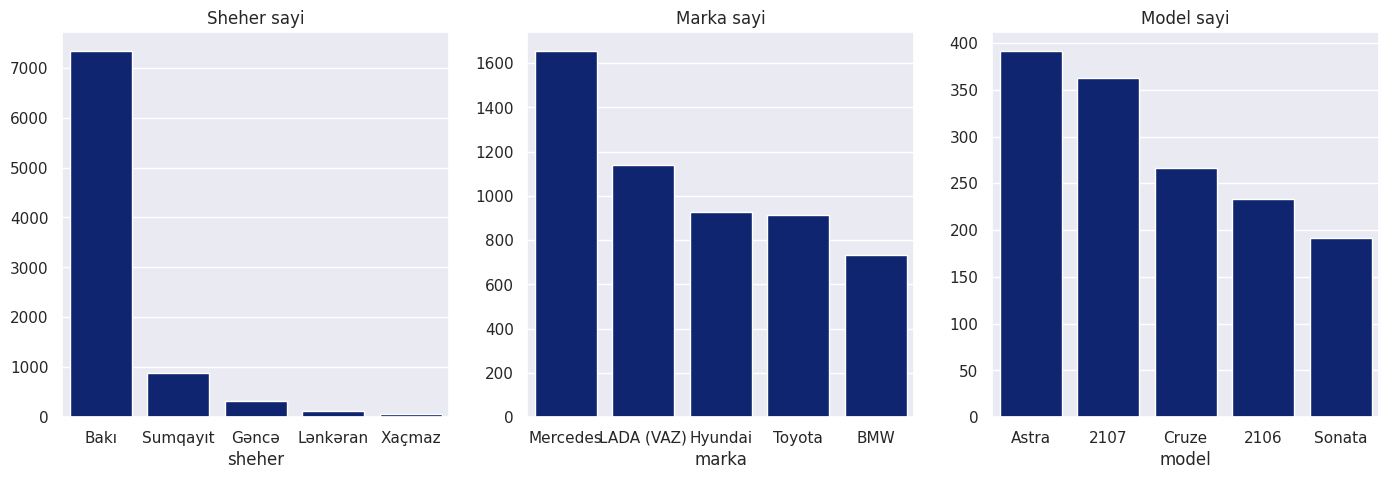

In [9]:
# most 5 cities, marka
cities = data.groupby('sheher',).count().sort_values('marka', ascending=False).iloc[:5, :1]
marka_sayi = data.groupby('marka',).count().sort_values('sheher', ascending=False).iloc[:5, :1]
model_sayi = data.groupby('model',).count().sort_values('sheher', ascending=False).iloc[:5, :1]


fig, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.barplot(ax=axes[0] ,x=cities.index, y=np.concatenate(cities.values))
axes[0].set_title('Sheher sayi')

sns.barplot(ax=axes[1] ,x=marka_sayi.index, y=np.concatenate(marka_sayi.values))
axes[1].set_title('Marka sayi')

sns.barplot(ax=axes[2] ,x=model_sayi.index, y=np.concatenate(model_sayi.values))
axes[2].set_title('Model sayi')

In [10]:
data[data.marka=='Toyota'].groupby('model').count().sort_values('marka', ascending=False).marka

model
Prado            179
Prius            155
Camry            135
Corolla          131
Land Cruiser      99
RAV 4             87
Highlander        42
C-HR              15
Hilux             12
Auris             10
Avensis            9
Avalon             8
Vitz               5
Yaris              4
Prius C            3
Yaris Cross        3
Prius V            3
Fortuner           2
FJ Cruiser         2
Tundra             2
Surf               2
Aurion             1
Rush               1
Sequoia            1
Urban Cruiser      1
Verso              1
Xa                 1
Name: marka, dtype: int64

<Axes: xlabel='qiymet_azn'>

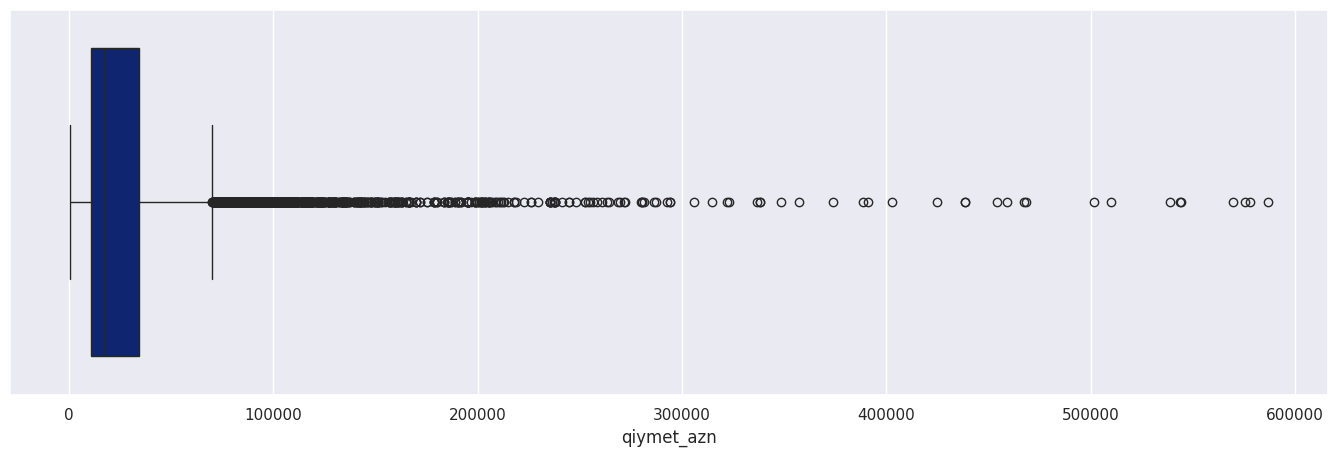

In [11]:
fig = plt.figure(figsize=(17,5))
sns.boxplot(data=data, x='qiymet_azn')

In [12]:
data[data.marka=='Toyota'].groupby('model').count().sort_values('marka', ascending=False).marka

model
Prado            179
Prius            155
Camry            135
Corolla          131
Land Cruiser      99
RAV 4             87
Highlander        42
C-HR              15
Hilux             12
Auris             10
Avensis            9
Avalon             8
Vitz               5
Yaris              4
Prius C            3
Yaris Cross        3
Prius V            3
Fortuner           2
FJ Cruiser         2
Tundra             2
Surf               2
Aurion             1
Rush               1
Sequoia            1
Urban Cruiser      1
Verso              1
Xa                 1
Name: marka, dtype: int64

### Modelling


In [13]:
import sklearn.preprocessing as sp

import sklearn.metrics as met
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [14]:
train, test = train_test_split(data, test_size=0.25, random_state=15)

In [15]:
#Marka avg
marka_avg = train.groupby(['marka']).agg({'qiymet_azn': 'mean'})
marka_avg.rename(columns={'qiymet_azn': 'marka_avg'}, inplace=True)

# Yanacaq avg
yanacaq_avg = train.groupby(['yanacaq_novu']).agg({'qiymet_azn': 'mean'})
yanacaq_avg.rename(columns={'qiymet_azn': 'yanacaq_avg'}, inplace=True)

# reng avg
reng_avg= train.groupby(['reng']).agg({'qiymet_azn': 'mean'})
reng_avg.rename(columns={'qiymet_azn': 'reng_avg'}, inplace=True)





train = train.merge(marka_avg, how='left', on='marka')
train = train.merge(yanacaq_avg, how='left', on='yanacaq_novu').merge(reng_avg, how='left', on='reng')


In [16]:
train.select_dtypes(include='number').columns.values

array(['buraxilish_ili', 'muherrik', 'muherrikin_gucu', 'yurush',
       'elan_id', 'baxish_sayi', 'car_age', 'qiymet_azn',
       'yüngül_lehimli_disklər', 'abs', 'yağış_sensoru',
       'mərkəzi_qapanma', 'park_radarı', 'kondisioner',
       'oturacaqların_isidilməsi', 'dəri_salon', 'ksenon_lampalar',
       'arxa_görüntü_kamerası', 'yan_pərdələr',
       'oturacaqların_ventilyasiyası', 'sheher_baki', 'tecili',
       'marka_avg', 'yanacaq_avg', 'reng_avg'], dtype=object)

In [17]:
polcols = ['muherrik', 'muherrikin_gucu', 'yurush', 'baxish_sayi', 'car_age',
       'yüngül_lehimli_disklər', 'abs', 'yağış_sensoru',
       'mərkəzi_qapanma', 'park_radarı', 'kondisioner',
       'oturacaqların_isidilməsi', 'dəri_salon', 'ksenon_lampalar',
       'arxa_görüntü_kamerası', 'yan_pərdələr',
       'oturacaqların_ventilyasiyası', 'sheher_baki', 'tecili',
       'karobka_Mexaniki', 'karobka_Robotlaşdırılmış', 'karobka_Variator',
       'ban_novu_Dartqı', 'ban_novu_Furqon', 'ban_novu_Hetçbek',
       'ban_novu_Kabriolet', 'ban_novu_Kupe',
       'ban_novu_Liftbek', 'ban_novu_Mikroavtobus', 'ban_novu_Minivan',
       'ban_novu_Moped', 'ban_novu_Motosiklet',
       'ban_novu_Offroader / SUV', 'ban_novu_Pikap', 'ban_novu_Rodster',
       'ban_novu_Sedan', 'ban_novu_Universal', 'ban_novu_Van',
       'ban_novu_Yük maşını', 'reng_Bej', 'reng_Boz', 'reng_Bənövşəyi',
       'reng_Göy', 'reng_Gümüşü', 'reng_Mavi', 'reng_Narıncı',
       'reng_Qara', 'reng_Qırmızı', 'reng_Qızılı', 'reng_Qəhvəyi',
       'reng_Sarı', 'reng_Tünd qırmızı', 'reng_Yaş Asfalt', 'reng_Yaşıl',
       'reng_Çəhrayı', 'yanacaq_novu_Dizel', 'yanacaq_novu_Elektro',
       'yanacaq_novu_Hibrid', 'yanacaq_novu_Plug-in Hibrid',
       'yanacaq_novu_Qaz', 'oturucu_Tam', 'oturucu_Ön', 'marka_avg',
       'yanacaq_avg', 'reng_avg']


ptrain = train[polcols]

In [18]:
poly = sp.PolynomialFeatures()

poly_train = pd.DataFrame(poly.fit_transform(ptrain), index=train.index)

In [19]:
poly_train = poly_train.iloc[:, len(polcols) + 1:]

In [20]:
cols = []
for i in range(len(polcols)):
    for  j in range(i, len(polcols)):
        cols.append(polcols[i] + '-->' + polcols[j])


In [21]:
len(cols) == poly_train.shape[1]

True

In [22]:
poly_train.columns = cols

In [23]:
train = train.join(poly_train, how='left')

In [24]:
train.head()

sheher       marka  model  buraxilish_ili    ban_novu     reng  muherrik  \
0  Qusar         GAZ  33021            1996  Yük maşını      Göy  2.400391   
1   Bakı  LADA (VAZ)  21011            1975       Sedan  Qırmızı  1.299805   
2   Bakı         BMW    318            1998       Sedan     Qara  1.799805   
3   Bakı      Zontes   R310            2021  Motosiklet     Mavi  0.000000   
4   Bakı         BMW    328            2013       Sedan     Qara  2.000000   

   muherrikin_gucu yanacaq_novu    yurush   karobka oturucu yeni  elan_id  \
0            131.0          Qaz  200000.0  Mexaniki    Arxa    1  6760042   
1             65.0       Benzin   22222.0  Mexaniki    Arxa    1  6761187   
2            118.0       Benzin  372000.0   Avtomat    Arxa    1  6758280   
3             35.0       Benzin    5900.0  Mexaniki    Arxa    1  6735684   
4            245.0       Benzin  120000.0   Avtomat    Arxa    1  6766894   

   yenilendi  baxish_sayi                  url  car_age  qiymet_azn  \
0 2022-10-23          903  https://turbo.az...       26      6500.0   
1 2022-10-23         1390  https://turbo.az...       47      1700.0   
2 2022-10-22         2292  https://turbo.az...       24      9800.0   
3 2022-10-26         9143  https://turbo.az...        1      7500.0   
4 2022-10-26         1052  https://turbo.az...        9     30600.0   

   yüngül_lehimli_disklər  abs  yağış_sensoru  mərkəzi_qapanma  park_radarı  \
0                    1       0              0                0            0   
1                    0       0              0                0            0   
2                    1       1              0                1            0   
3                    1       1              0                0            0   
4                    0       0              0                0            0   

   kondisioner  oturacaqların_isidilməsi  dəri_salon  ksenon_lampalar  \
0            0                    0                0                0   
1            0                    0                0                0   
2            1                    0                0                1   
3            0                    0                0                0   
4            0                    0                0                0   

   arxa_görüntü_kamerası  yan_pərdələr  oturacaqların_ventilyasiyası  \
0                    0               0                    0            
1                    0               0                    0            
2                    0               1                    0            
3                    0               0                    0            
4                    0               0                    0            

   sheher_baki  tecili  karobka_Mexaniki  karobka_Robotlaşdırılmış  \
0            0       0              True                False        
1            1       0              True                False        
2            1       0             False                False        
3            1       0              True                False        
4            1       0             False                False        

   karobka_Variator  ban_novu_Dartqı  ban_novu_Furqon  ban_novu_Hetçbek  \
0             False            False            False             False   
1             False            False            False             False   
2             False            False            False             False   
3             False            False            False             False   
4             False            False            False             False   

   ban_novu_Kabriolet  ban_novu_Kupe  ban_novu_Liftbek  ban_novu_Mikroavtobus  \
0               False          False             False                False     
1               False          False             False                False     
2               False          False             False                False     
3               False          False             False                False     
4               Fal

In [25]:
import numpy as np
numeric_train = train.select_dtypes(include=np.number)

cor = numeric_train.corr()

strong_cors = cor['qiymet_azn'][(abs(cor.qiymet_azn) >= 0.3) & (abs(cor.qiymet_azn) != 1)]
strong_cors

buraxilish_ili                                                 0.488517
muherrik                                                       0.340924
muherrikin_gucu                                                0.636928
yurush                                                        -0.336053
car_age                                                       -0.488517
yağış_sensoru                                                  0.326490
park_radarı                                                    0.371021
oturacaqların_isidilməsi                                       0.367309
dəri_salon                                                     0.362627
ksenon_lampalar                                                0.317249
arxa_görüntü_kamerası                                          0.393081
oturacaqların_ventilyasiyası                                   0.321285
marka_avg                                                      0.578047
muherrik-->muherrikin_gucu                                     0

In [26]:
train.select_dtypes(include='number').columns

Index(['buraxilish_ili', 'muherrik', 'muherrikin_gucu', 'yurush', 'elan_id',
       'baxish_sayi', 'car_age', 'qiymet_azn', 'yüngül_lehimli_disklər', 'abs',
       ...
       'oturucu_Ön-->oturucu_Ön', 'oturucu_Ön-->marka_avg',
       'oturucu_Ön-->yanacaq_avg', 'oturucu_Ön-->reng_avg',
       'marka_avg-->marka_avg', 'marka_avg-->yanacaq_avg',
       'marka_avg-->reng_avg', 'yanacaq_avg-->yanacaq_avg',
       'yanacaq_avg-->reng_avg', 'reng_avg-->reng_avg'],
      dtype='object', length=2170)

In [27]:
def test_creator(test):
    test = test.merge(marka_avg, how='left', on='marka')
    test = test.merge(yanacaq_avg, how='left', on='yanacaq_novu').merge(reng_avg, how='left', on='reng')
    test.dropna(inplace=True)
    ptest = test[polcols]
    poly_test = pd.DataFrame(poly.fit_transform(ptest), index=test.index)
    poly_test = poly_test.iloc[:, len(polcols) + 1:]
    poly_test.columns = cols
    test = test.join(poly_test, how='left')

    return test
test = test_creator(test)

In [28]:
my_X_variables = strong_cors.index
y_variable = 'qiymet_azn'

def Xy_sep(test):
    X_train = train[my_X_variables]
    X_test = test[my_X_variables]
    y_train = np.log(train[y_variable])
    y_test = np.log(test[y_variable])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = Xy_sep(test)

In [29]:
X_train.head()

,buraxilish_ili,muherrik,muherrikin_gucu,yurush,car_age,yağış_sensoru,park_radarı,oturacaqların_isidilməsi,dəri_salon,ksenon_lampalar,arxa_görüntü_kamerası,oturacaqların_ventilyasiyası,marka_avg,muherrik-->muherrikin_gucu,muherrik-->baxish_sayi,muherrik-->yüngül_lehimli_disklər,muherrik-->abs,muherrik-->yağış_sensoru,muherrik-->mərkəzi_qapanma,muherrik-->park_radarı,muherrik-->kondisioner,muherrik-->oturacaqların_isidilməsi,muherrik-->dəri_salon,muherrik-->ksenon_lampalar,muherrik-->arxa_görüntü_kamerası,muherrik-->oturacaqların_ventilyasiyası,muherrik-->sheher_baki,muherrik-->ban_novu_Offroader / SUV,muherrik-->reng_Qara,muherrik-->oturucu_Tam,muherrik-->marka_avg,muherrik-->yanacaq_avg,muherrik-->reng_avg,muherrikin_gucu-->muherrikin_gucu,muherrikin_gucu-->baxish_sayi,muherrikin_gucu-->yüngül_lehimli_disklər,muherrikin_gucu-->abs,muherrikin_gucu-->yağış_sensoru,muherrikin_gucu-->mərkəzi_qapanma,muherrikin_gucu-->park_radarı,muherrikin_gucu-->kondisioner,muherrikin_gucu-->oturacaqların_isidilməsi,muherrikin_gucu-->dəri_salon,muherrikin_gucu-->ksenon_lampalar,muherrikin_gucu-->arxa_görüntü_kamerası,muherrikin_gucu-->yan_pərdələr,muherrikin_gucu-->oturacaqların_ventilyasiyası,muherrikin_gucu-->sheher_baki,muherrikin_gucu-->ban_novu_Offroader / SUV,muherrikin_gucu-->reng_Qara,muherrikin_gucu-->oturucu_Tam,muherrikin_gucu-->marka_avg,muherrikin_gucu-->yanacaq_avg,muherrikin_gucu-->reng_avg,yurush-->car_age,yurush-->yanacaq_avg,baxish_sayi-->yağış_sensoru,baxish_sayi-->park_radarı,baxish_sayi-->oturacaqların_isidilməsi,baxish_sayi-->dəri_salon,baxish_sayi-->arxa_görüntü_kamerası,baxish_sayi-->oturacaqların_ventilyasiyası,baxish_sayi-->ban_novu_Offroader / SUV,baxish_sayi-->oturucu_Tam,baxish_sayi-->marka_avg,car_age-->car_age,car_age-->yüngül_lehimli_disklər,car_age-->karobka_Mexaniki,car_age-->ban_novu_Sedan,car_age-->yanacaq_avg,car_age-->reng_avg,yüngül_lehimli_disklər-->yağış_sensoru,yüngül_lehimli_disklər-->park_radarı,yüngül_lehimli_disklər-->oturacaqların_isidilməsi,yüngül_lehimli_disklər-->dəri_salon,yüngül_lehimli_disklər-->ksenon_lampalar,yüngül_lehimli_disklər-->arxa_görüntü_kamerası,yüngül_lehimli_disklər-->oturacaqların_ventilyasiyası,yüngül_lehimli_disklər-->ban_novu_Offroader / SUV,yüngül_lehimli_disklər-->oturucu_Tam,yüngül_lehimli_disklər-->marka_avg,abs-->yağış_sensoru,abs-->park_radarı,abs-->oturacaqların_isidilməsi,abs-->dəri_salon,abs-->ksenon_lampalar,abs-->arxa_görüntü_kamerası,abs-->oturacaqların_ventilyasiyası,abs-->ban_novu_Offroader / SUV,abs-->oturucu_Tam,abs-->marka_avg,abs-->reng_avg,yağış_sensoru-->yağış_sensoru,yağış_sensoru-->mərkəzi_qapanma,yağış_sensoru-->park_radarı,yağış_sensoru-->kondisioner,yağış_sensoru-->oturacaqların_isidilməsi,yağış_sensoru-->dəri_salon,yağış_sensoru-->ksenon_lampalar,yağış_sensoru-->arxa_görüntü_kamerası,yağış_sensoru-->oturacaqların_ventilyasiyası,yağış_sensoru-->sheher_baki,yağış_sensoru-->ban_novu_Offroader / SUV,yağış_sensoru-->oturucu_Tam,yağış_sensoru-->marka_avg,yağış_sensoru-->yanacaq_avg,yağış_sensoru-->reng_avg,mərkəzi_qapanma-->park_radarı,mərkəzi_qapanma-->oturacaqların_isidilməsi,mərkəzi_qapanma-->dəri_salon,mərkəzi_qapanma-->ksenon_lampalar,mərkəzi_qapanma-->arxa_görüntü_kamerası,mərkəzi_qapanma-->oturacaqların_ventilyasiyası,mərkəzi_qapanma-->ban_novu_Offroader / SUV,mərkəzi_qapanma-->oturucu_Tam,mərkəzi_qapanma-->marka_avg,mərkəzi_qapanma-->reng_avg,park_radarı-->park_radarı,park_radarı-->kondisioner,park_radarı-->oturacaqların_isidilməsi,park_radarı-->dəri_salon,park_radarı-->ksenon_lampalar,park_radarı-->arxa_görüntü_kamerası,park_radarı-->oturacaqların_ventilyasiyası,park_radarı-->sheher_baki,park_radarı-->ban_novu_Offroader / SUV,park_radarı-->reng_Qara,park_radarı-->oturucu_Tam,park_radarı-->marka_avg,park_radarı-->yanacaq_avg,park_radarı-->reng_avg,kondisioner-->oturacaqların_isidilməsi,kondisioner-->dəri_salon,kondisioner-->ksenon_lampalar,kondisioner-->arxa_görüntü_kamerası,kondisioner-->oturacaqların_ventilyasiyası,kondisioner-->ban_novu_Offroade

In [30]:
params_rf = dict(n_estimators=[400, 600, 800])

pipe = Pipeline([('scaler', sp.RobustScaler()),
                 ('Grid', GridSearchCV(RandomForestRegressor(), params_rf, verbose=2, n_jobs=-1, cv=2,
                                       scoring='neg_mean_absolute_error'))])
pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print("train mean error:", met.mean_absolute_error(train['qiymet_azn'], np.exp(y_pred_train)),
      ", train median error:", met.median_absolute_error(train['qiymet_azn'], np.exp(y_pred_train)))
print("test mean error:", met.mean_absolute_error(test['qiymet_azn'], np.exp(y_pred_test)),
      ", test median error:", met.median_absolute_error(test['qiymet_azn'], np.exp(y_pred_test)))

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ...................................n_estimators=400; total time=  58.6s
[CV] END ...................................n_estimators=400; total time= 1.0min
[CV] END ...................................n_estimators=600; total time= 1.3min
[CV] END ...................................n_estimators=800; total time= 1.8min
[CV] END ...................................n_estimators=600; total time= 1.8min
[CV] END ...................................n_estimators=800; total time= 2.0min
train mean error: 1759.0501716571923 , train median error: 561.5002801341936
test mean error: 4250.9067402345945 , test median error: 1415.0972741432306


### Real fərqli data testi

In [31]:
df = pd.read_csv('turbo_az_2022-11-06.csv')

In [32]:
df = data_clean(df)

In [33]:
df['yenilendi'] = pd.to_datetime(df['yenilendi'].dt.strftime('%Y-%d-%m'))

In [34]:
df = df[(df.yenilendi.dt.month ==11) & (df.yenilendi.dt.day ==6)]

In [35]:
df = test_creator(df)
output = Xy_sep(df)

In [36]:
show_real = pd.concat([pd.DataFrame({'predicted': np.round(np.exp(pipe.predict(output[1])), 1),
               'real': np.round(np.exp(output[3]), 1)    
             }), df['url'] ], axis=1)

In [37]:
show_real

,predicted,real,url
0,50166.4,44030.0,https://turbo.az...
1,16295.7,18900.0,https://turbo.az...
2,25421.7,23600.0,https://turbo.az...
3,35778.3,33998.3,https://turbo.az...
4,16935.9,12000.0,https://turbo.az...
5,7839.7,8900.0,https://turbo.az...
6,25681.1,26000.0,https://turbo.az...
7,10527.9,11900.0,https://turbo.az...
8,15711.0,19000.0,https://turbo.az...
9,326248.3,425000.0,https://turbo.az...


In [45]:
y_pred = np.exp(pipe.predict(output[1]))
y_real = np.exp(output[3])

results_df = pd.DataFrame({
    'Gerçek Fiyat': np.round(y_real, 0).astype(int),
    'Tahmin': np.round(y_pred, 0).astype(int),
    'Fark': np.round(y_pred - y_real, 0).astype(int),
    'Hata %': np.round(np.abs((y_pred - y_real) / y_real * 100), 1),
    'URL': df['url'].values
})

